# TensorFlow 2 and Keras quickstart for geospatial computer vision

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) and is adapted from this [example](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

Our objectives will be to:
1. Load prebuilt geospatial datasets. We'll show how to do this firstly with [TensorFlow Datasets](https://www.tensorflow.org/datasets) and secondly with [Radiant Earth MLHub](https://mlhub.earth/).
1. Build a neural network machine learning model that classifies images.
1. Train this neural network.
1. Evaluate the accuracy of the model.

Let's check the python version we are using. This is subject to Google colab internal updates, so be mindful of when this changes and how that impacts library versions you might be using.

In [113]:
!python3 --version

Python 3.10.12


In [2]:
# install required libraries
!pip install -q rasterio==1.3.8
!pip install -q geopandas==0.13.2
#!pip install -q tensorflow-data-validation==1.3.0 # Only works with Python versions 3.9 or earlier
#!export TFX_DEPENDENCY_SELECTOR=NIGHTLY
#!pip install -q --extra-index-url https://pypi-nightly.tensorflow.org/simple tensorflow-data-validation
!pip install -q radiant_mlhub # for dataset access, see: https://mlhub.earth/

In [3]:
import os, glob, functools, fnmatch, io, shutil, tarfile, json
from zipfile import ZipFile
from itertools import product
from pathlib import Path
import urllib.request
from radiant_mlhub import Dataset, client, get_session, Collection
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from google.colab import drive
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
#import tensorflow_data_validation
import matplotlib.pyplot as plt

Import TensorFlow into your program to get started:

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


Mount our folders to read and write data.

In [ ]:
# set your folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    drive.mount('/content/gdrive')
    processed_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-2-processed-outputs/'
    user_outputs_dir = '/content/gdrive/My Drive/tf-eo-devseed-2-user_outputs_dir'
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
    print('Running on Colab')
else:
    processed_outputs_dir = os.path.abspath("./data/tf-eo-devseed-2-processed-outputs")
    user_outputs_dir = os.path.abspath('./tf-eo-devseed-2-user_outputs_dir')
    if not os.path.exists(user_outputs_dir):
        os.makedirs(user_outputs_dir)
        os.makedirs(processed_outputs_dir)
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(processed_outputs_dir)}')

In [ ]:
# Move to your user directory in order to write data
%cd $user_outputs_dir

## Let's use a dataset from TensorFlow Datasets

[TensorFlow Datasets](https://www.tensorflow.org/datasets), accessible via the importable API `tfds`, is convenient compared to working with raw geotiffs from file, as the associated pre-packaged datasets are accompanied by TensorFlow's ecosystem of methods for attribution and exploration. The standardized packaging of these datasets also makes it easier to parallelize pre-processing operations which in turn makes it easier to create simple and efficient data pipelines.

We will use the Eurosat dataset, which contains labeled Sentinel-2 image patches classified into 10 land cover types. More details here: https://www.tensorflow.org/datasets/catalog/eurosat

The classes in this dataset are: `['Industrial', 'Pasture', 'River', 'Forest', 'AnnualCrop', 'PermanentCrop', 'Highway', 'HerbaceousVegetation', 'Residential', 'SeaLake']`

The dataset will be partitioned into training, validation and testing splits with a 70:20:10 ratio, respectively.

In [8]:
def convert_datasets(dataset, image_arrays_list, label_integers_list):
  """
  Prepares a dict-style dataset in the format Keras expects, (features, labels).
  """
  for features in dataset.take(len(dataset)):
    image, label = features["image"], features["label"]
    image_arrays_list.append(image)
    label_integers_list.append(label)
  x_dataset, y_dataset = np.array(image_arrays_list), np.array(label_integers_list)
  return x_dataset, y_dataset


In [9]:
# Construct tf.data.Dataset(s)
all_dataset, ds_info = tfds.load(name="eurosat/rgb", split=tfds.Split.TRAIN, with_info=True)

# Shuffle the data before we partition it to make sure we don't have any unwarranted bias
all_dataset = all_dataset.shuffle(1024)
# Extract 30% of samples from the dataset for non-training
val_dataset = all_dataset.take(int(len(all_dataset)*0.3))
# Ensure that 30% of samples is excluded ("skipped") when we set the training dataset
train_dataset = all_dataset.skip(int(len(all_dataset)*0.3))
# Take 30% of the non-training samples to use for testing, this makes up approaximately 10% of the original dataset
test_dataset = val_dataset.take(int(len(val_dataset)*0.3))
# Make sure the validation data skips that test reserve
val_dataset = val_dataset.skip(int(len(val_dataset)*0.3))

print("Number of samples in each split (train, val, test): ", len(train_dataset), len(val_dataset), len(test_dataset))

train_image_arrays = []
train_label_integers = []
val_image_arrays = []
val_label_integers = []
test_image_arrays = []
test_label_integers = []

x_train, y_train = convert_datasets(train_dataset, train_image_arrays, train_label_integers)
x_val, y_val = convert_datasets(val_dataset, val_image_arrays, val_label_integers)
x_test, y_test = convert_datasets(test_dataset, test_image_arrays, test_label_integers)

Number of samples in each split (train, val, test):  18900 5670 2430


In [ ]:
# Check for all classes in each split
# set(train_label_integers), set(test_label_integers)

In [10]:
# Dataset specific parameters to be used in the model structure
INPUT_SHAPE =(64, 64, 3)
NUM_CLASSES = 10

Let's visualize examples of the classes in the dataset

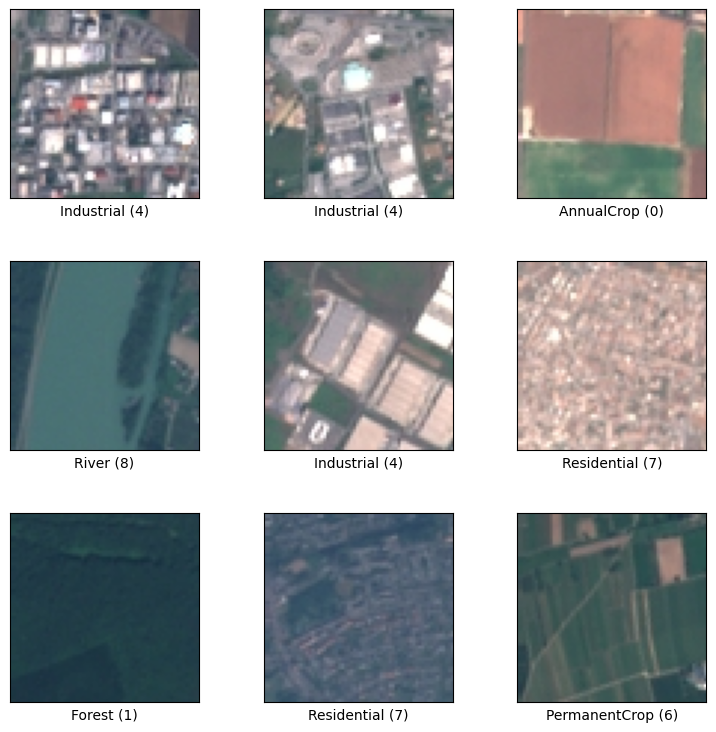

In [11]:
fig = tfds.show_examples(all_dataset, ds_info)

We can also inspect some statistics on the dataset. NOTE: The dependencies for this function are unstable in Python versions `>3.9` and may not work as intended under such circumstances.

In [ ]:
#tfds.show_statistics(ds_info)

## Now, let's build a very basic machine learning model

We'll use the `tf.keras.Sequential` model structure:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(NUM_CLASSES)
])

The [`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) structure is designed to stack layers where each layer has an input [a tensor](https://www.tensorflow.org/guide/tensor) and an output tensor. Layers themselves are simply functions performing matrix calculations. They may contain trainable variables and are reusable.

It is most common for TensorFlow models to be composed of layers. This sequential model is composed of the [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

For each data sample provided the model, the corresponding output is a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, for each class.

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

The `tf.nn.softmax` function converts logits to *probabilities* for each class:

In [ ]:
tf.nn.softmax(predictions).numpy()

In [ ]:
tf.nn.softmax(predictions).numpy().min(), tf.nn.softmax(predictions).numpy().max()

(0.0, 1.0)

The next step is to specify a loss function for training. We will be using `losses.SparseCategoricalCrossentropy` as it is a commonly used loss function for multi-class data:

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The input to the loss function is a vector of ground truth values and a vector of logits. The returned output is a scalar loss for each data sample. Loss values close to zero are good, as they imply proximity to the correct class.

The untrained model will produce probabilities close to random for each class.

Before the model can be trained, it needs to be configured and compiled, using Keras `Model.compile`. In this step, we establish the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class (which in this case will be `adam`), the `loss` to the `loss_fn` function defined earlier, and a metric that will be used evaluate the model at each iteration (herein we will use `accuracy`).

In [ ]:
lr = 0.001 # learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr) # optimizer

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# Summarize the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               1572992   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,574,282
Trainable params: 1,574,282
Non-trainable params: 0
_________________________________________________________________


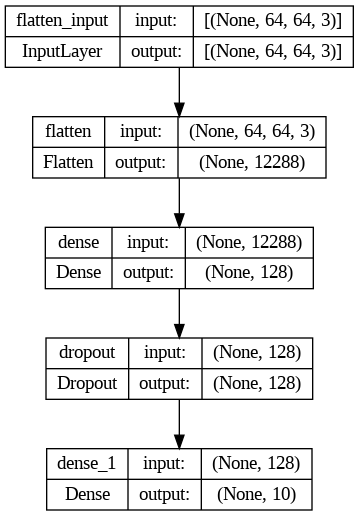

In [ ]:
# Visualize the model
plot_model(model, show_shapes=True)

## Train and evaluate your model

No we will train the model using the `Model.fit` Keras method. During the following iterations, the model parameters will adjust and we will hope to see the loss.

In [ ]:
# We will save the model fit history as an object to subsequently get attributes from (e.g. loss curves).
# This is an optional measure.
history = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs=10)

In [ ]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

To evaluate the mode, we will use the `Model.evaluate` Keras method. The performance is evaluated on a [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

We can return probabilities for the predictions by attaching a softmax to the trained model.

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

Now, let's take the first test image, plot it and get the predicted class-wise probabilities.

In [ ]:
import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(5, 5))

  title = ['Test Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

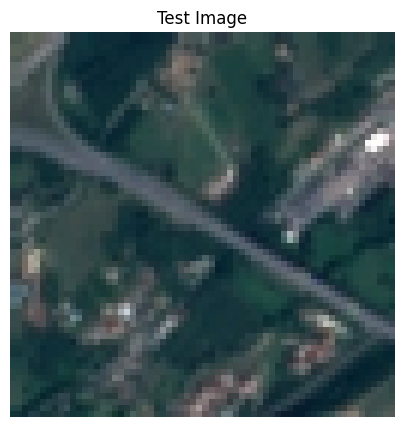

In [ ]:
# display sample test image
display([x_test[0]])

In [ ]:
probabilities = probability_model(x_test[[0]])
probabilities

In [ ]:
class_strings = ['Industrial', 'Pasture', 'River', 'Forest', 'AnnualCrop', 'PermanentCrop', 'Highway', 'HerbaceousVegetation', 'Residential', 'SeaLake']

Which class has the highest probability?

In [ ]:
for s, p in zip(class_strings, probabilities[0]):
  print(s, p)

We can look at some ground truth examples again to see if this looks sound!

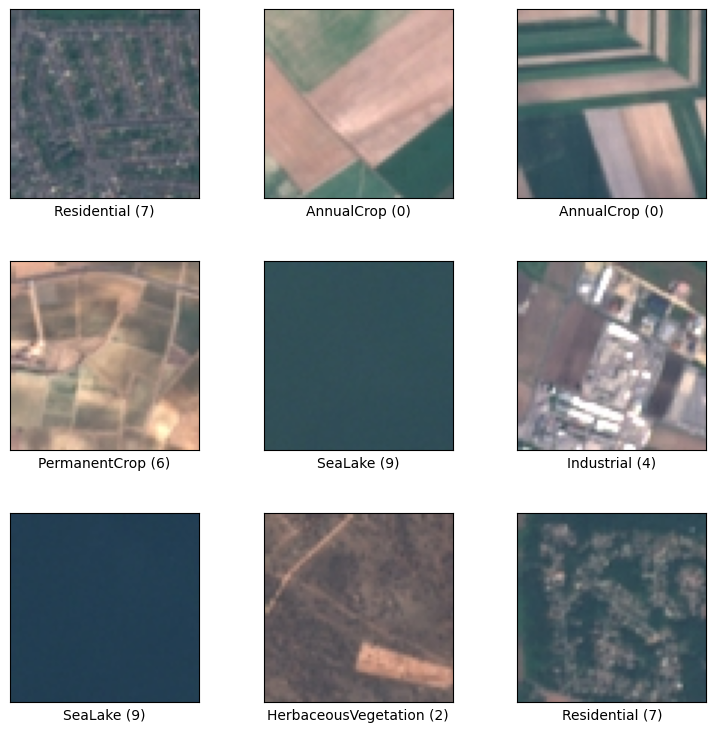

In [ ]:
fig = tfds.show_examples(all_dataset, ds_info)

## Part 2 (optional) using same modeling approach but with a dataset from Radiant Earth

Load and prepare the [Drone Imagery Classification Training Dataset for Crop Types in Rwanda dataset from Radiant Earth](https://mlhub.earth/data/rti_rwanda_crop_type). You'll need a Radiant Earth MLHub API key for this.

In [ ]:
# configure Radiant Earth MLHub access
!mlhub configure

In [ ]:
ds = Dataset.fetch('rti_rwanda_crop_type')
for c in ds.collections:
    print(c.id)


rti_rwanda_crop_type_labels
rti_rwanda_crop_type_source
rti_rwanda_crop_type_raw


In [ ]:
collections = [
    'rti_rwanda_crop_type_labels',
    'rti_rwanda_crop_type_source'
]

def download(collection_id):
    print(f'Downloading {collection_id}...')
    collection = Collection.fetch(collection_id)
    path = collection.download('.')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(path)

def resolve_path(base, path):
    return Path(os.path.join(base, path)).resolve()

def load_df(collection_id):
    collection = json.load(open(f'{collection_id}/collection.json', 'r'))
    rows = []
    item_links = []
    for link in collection['links']:
        if link['rel'] != 'item':
            continue
        item_links.append(link['href'])
    for item_link in item_links:
        item_path = f'{collection_id}/{item_link}'
        current_path = os.path.dirname(item_path)
        item = json.load(open(item_path, 'r'))
        tile_id = item['id'].split('_')[-1]
        for asset_key, asset in item['assets'].items():
            rows.append([
                tile_id,
                None,
                None,
                asset_key,
                str(resolve_path(current_path, asset['href']))
            ])

        for link in item['links']:
            if link['rel'] != 'source':
                continue
            link_path = resolve_path(current_path, link['href'])
            source_path = os.path.dirname(link_path)
            try:
                source_item = json.load(open(link_path, 'r'))
            except FileNotFoundError:
                continue
            datetime = source_item['properties']['datetime']
            satellite_platform = source_item['collection'].split('_')[-1]
            for asset_key, asset in source_item['assets'].items():
                rows.append([
                    tile_id,
                    datetime,
                    satellite_platform,
                    asset_key,
                    str(resolve_path(source_path, asset['href']))
                ])
    return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

for c in collections:
    download(c)

train_df = load_df('rti_rwanda_crop_type_labels')
#test_df = load_df('rti_rwanda_crop_type_labels')

In [ ]:
# Read the classes
pd.set_option('display.max_colwidth', None)

data = {'class_names':  ['other', 'banana', 'maize', 'legumes', 'forest', 'structure'],
        'class_ids': [0, 1, 2, 3, 4, 5]
        }

classes = pd.DataFrame(data)
print(classes)

classes.to_csv('rti_rwanda_crop_type_classes.csv')

  class_names  class_ids
0       other          0
1      banana          1
2       maize          2
3     legumes          3
4      forest          4
5   structure          5


In [ ]:
train_df_labels = train_df.loc[train_df['asset'] == 'labels']

In [ ]:
data_train, data_test = train_test_split(train_df_labels, test_size=0.3, random_state=1)

In [ ]:
len(data_train), len(data_test)

(1824, 782)

In [ ]:
def get_RE_train_test(dataset, image_array_list, label_integer_list):
  for i, r in data_train.iterrows():
    label_path = r.file_path
    with open(label_path) as f:
      label_obj = json.load(f)
    label_str = label_obj['label']
    label_int = classes.loc[classes['class_names'] == label_str, 'class_ids'].squeeze()
    label_integer_list.append(label_int)
    image_path = label_path.replace('labels', 'source')
    image_path = image_path.replace('source.json', '')
    image_obj = np.array(Image.open(f"{image_path}/image.png"))
    image_array_list.append(image_obj)
  return image_array_list, label_integer_list

In [ ]:
train_image_arrays = []
train_label_integers = []

train_image_arrays, train_label_integers = get_RE_train_test(data_train, train_image_arrays, train_label_integers)

In [ ]:
test_image_arrays = []
test_label_integers = []

test_image_arrays, test_label_integers = get_RE_train_test(data_test, test_image_arrays, test_label_integers)

In [ ]:
set(train_label_integers), set(test_label_integers)

({0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5})

In [ ]:
x_train, y_train = np.array(train_image_arrays), np.array(train_label_integers)
x_test, y_test = np.array(test_image_arrays), np.array(test_label_integers)

In [ ]:
INPUT_SHAPE = (200, 200, 3)
NUM_CLASSES = 6

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(NUM_CLASSES)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=5)

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])